<a href="https://colab.research.google.com/github/gigakuma/my-notebooks/blob/main/genshin_finetuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genshin Impact! Fine-tuning CLIP for anime search

Today let's build a search-anime system. We will use text as our query and get images as result. For this we would usually need to manually annotate the image with some tags, often referred to as `TBIR` (Text/Tag-based Image Retrieval). And for this example, we will use [OpenAI CLIP](https://github.com/openai/CLIP).

CLIP is a powerful embedding model that outputs the similarity between text and images. And while it delivers great results, its zero-shot capability needs to be improved on domain data.

We'll build our search system using [Jina](https://docs.jina.ai/) with CLIP as the encoder. But since we already said that CLIP needs to improve its zero-shot capabilities, we will fine-tune our model with [Finetuner](https://github.com/jina-ai/finetuner). But we want to make sure fine-tuning is improving our results, so to examine the effectiveness of the original CLIP on an anime dataset, we'll fine-tune the CLIP model with half of the dataset, then see if the search results improve.

## The data

![Albedo](https://storage.googleapis.com/kaggle-datasets-images/2071434/3438247/7cae3f8ae6d0e09f93df60bea523f7aa/dataset-cover.jpg?t=2022-04-10-16-04-06)

The dataset is a public dataset from [Kaggle](https://www.kaggle.com/datasets/just1ce5/genshin-impact-characters-dataset) from the popular game [Genshin Impact](https://genshin.hoyoverse.com/pc-launcher/?utm_source=EU_google_DE_search_20220720&mhy_trace_channel=ga_channel&new=1&gclid=Cj0KCQjwz96WBhC8ARIsAATR250k1qTcxh8i1saR-tXXDt3SFlk2XGV93oMz3DZEF8T7Zs8RrTxT0LIaAgFUEALw_wcB#/GI008). It contatins five categories: four Genshin characters and one for 'None of them'

- Albedo
- Ayaka
- Hu Tao
- Kokomi
- Nether (None of these characters)

Each character has 100 images, for a total of 500 images. We'll fine-tune `CLIP` with only 250 images.

## Download data and install dependencies

In [ ]:
!pip install -U "finetuner[full]" # finetuner-full will install ML libraries such as torchvision and transformers

!pip install gdown
!pip install git+https://github.com/openai/CLIP.git

In [ ]:
!pip show finetuner

Name: finetuner
Version: 0.6.7
Summary: Task-oriented finetuning for better embeddings on neural search.
Home-page: https://github.com/jina-ai/finetuner/
Author: Jina AI
Author-email: hello@jina.ai
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: jina-hubble-sdk, finetuner-stubs, docarray
Required-by: 


In [ ]:
!gdown https://drive.google.com/uc?id=1i4UdF-DwiR00HUNFYsyXI5bmOqCdLLtJ
!unzip /content/dataset.zip

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1i4UdF-DwiR00HUNFYsyXI5bmOqCdLLtJ 

unzip:  cannot find or open /content/dataset.zip, /content/dataset.zip.zip or /content/dataset.zip.ZIP.


## Zero-Shot CLIP Retrieval

Now we have downloaded the dataset in the `/content/dataset/` folder. We'll use `docarray` to build a search system, and use pre-trained `CLIP ViT-B/32` as the encoder to encode the images.

We'll construct some text queries about the Gineshi characters, such as `Ayaka dancing`, `Hu Tao fighting`, `Albedo fly` etc, to see if the zero-shot CLIP works.

In [ ]:
from docarray import Document, DocumentArray

da = DocumentArray.from_files('/content/dataset/*/*.*')

def assign_labels(d: Document):
    d.tags['finetuner_label'] = d.uri.split('/')[3]
    return d

da.apply(assign_labels, show_progress=True)
# shuffle and train-test-split to 50-50
da = da.shuffle()
train_da = da[:250]
test_da = da[250:]

Output()

In [ ]:
test_da[0]

IndexError: ignored

In [ ]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

def preprocess_and_encode_image(d: Document):
    """Preprocess image and extract embeddings from CLIP image encoder"""
    d.tensor = preprocess(Image.open(d.uri)).unsqueeze(0).to(device)
    d.embedding = model.encode_image(d.tensor).cpu().detach().numpy().squeeze()
    d.pop('tensor')
    return d

def preprocess_and_encode_text(d: Document):
    """Preprocess image and extract embeddings from CLIP text encoder"""
    d.tensor = clip.tokenize(d.text).to(device)
    d.embedding = model.encode_text(d.tensor).cpu().detach().numpy().squeeze()
    d.pop('tensor')
    return d

100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 92.8MiB/s]


Now we have our data and pre-processing functions ready. The next steps are:

1. Apply feature extraction on all the `test_da`.

2. Construct some text queries to find similar image Documents.

In [ ]:
# embed all test documents
test_da.apply(preprocess_and_encode_image, show_progress=True)

Output()

╭──────────────────────────── Documents Summary ─────────────────────────────╮
│                                                                            │
│   Type                   DocumentArrayInMemory                             │
│   Length                 250                                               │
│   Homogenous Documents   True                                              │
│   Common Attributes      ('id', 'mime_type', 'uri', 'tags', 'embedding')   │
│   Multimodal dataclass   False                                             │
│                                                                            │
╰────────────────────────────────────────────────────────────────────────────╯
╭────────────────────── Attributes Summary ───────────────────────╮
│                                                                 │
│   Attribute   Data type      #Unique values   Has empty value   │
│  ─────────────────────────────────────────────────────────────  │
│   embedding   ('ndarray',)   250              False             │
│   id          ('str',)       250              False             │
│   mime_type   ('str',)       1                False             │
│   tags        ('dict',)      250              False             │
│   uri         ('str',)       250              False             │
│                                                                 │
╰─────────────────────────────────────────────────────────────────╯

The matched document agains query Hu Tao fighting at position 0 is Albedo


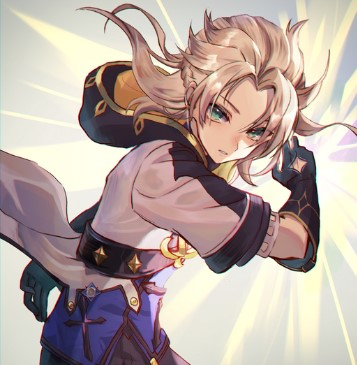

The matched document agains query Hu Tao fighting at position 1 is Ayaka


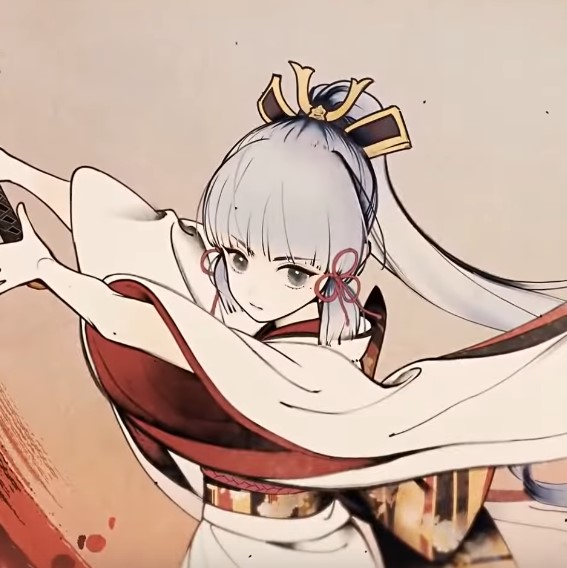

The matched document agains query Hu Tao fighting at position 2 is Ayaka


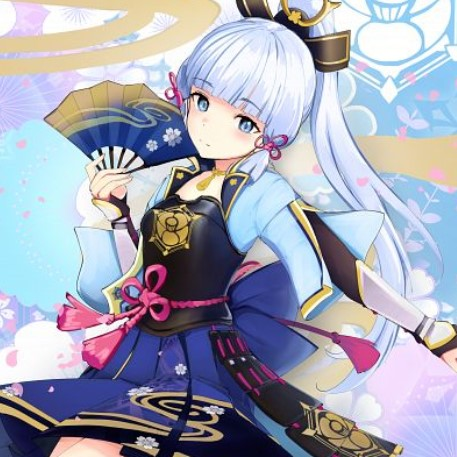

The matched document agains query Hu Tao fighting at position 3 is Neither


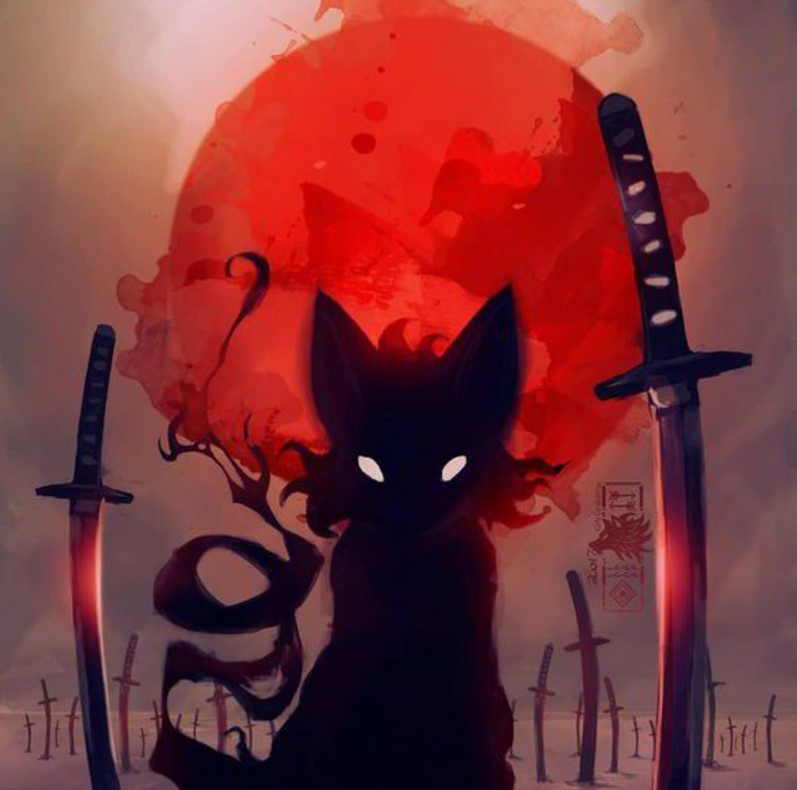

The matched document agains query Hu Tao fighting at position 4 is Hu Tao


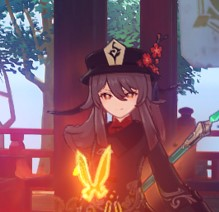

In [ ]:
# embed a user query
query = 'Hu Tao fighting'
query_docs = DocumentArray([Document(content=query)])
query_docs.apply(preprocess_and_encode_text)
# find top 5 matches
query_docs.match(test_da, metric='cosine', limit=5)
# plot matches
for idx, match in enumerate(query_docs[0].matches):
    print(f'The matched document agains query \033[1m{query}\033[0m at position \033[1m{idx}\033[0m is \033[1m{match.tags["finetuner_label"]}\033[0m')
    match.display()

The matched document agains query Ayaka dancing at position 0 is Kokomi


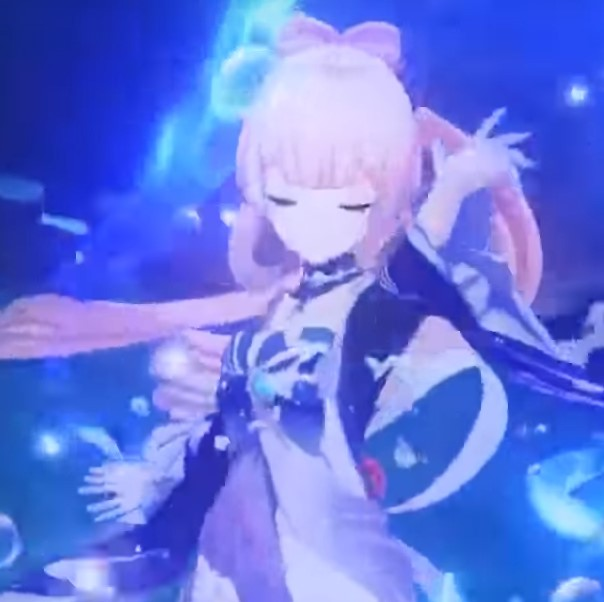

The matched document agains query Ayaka dancing at position 1 is Ayaka


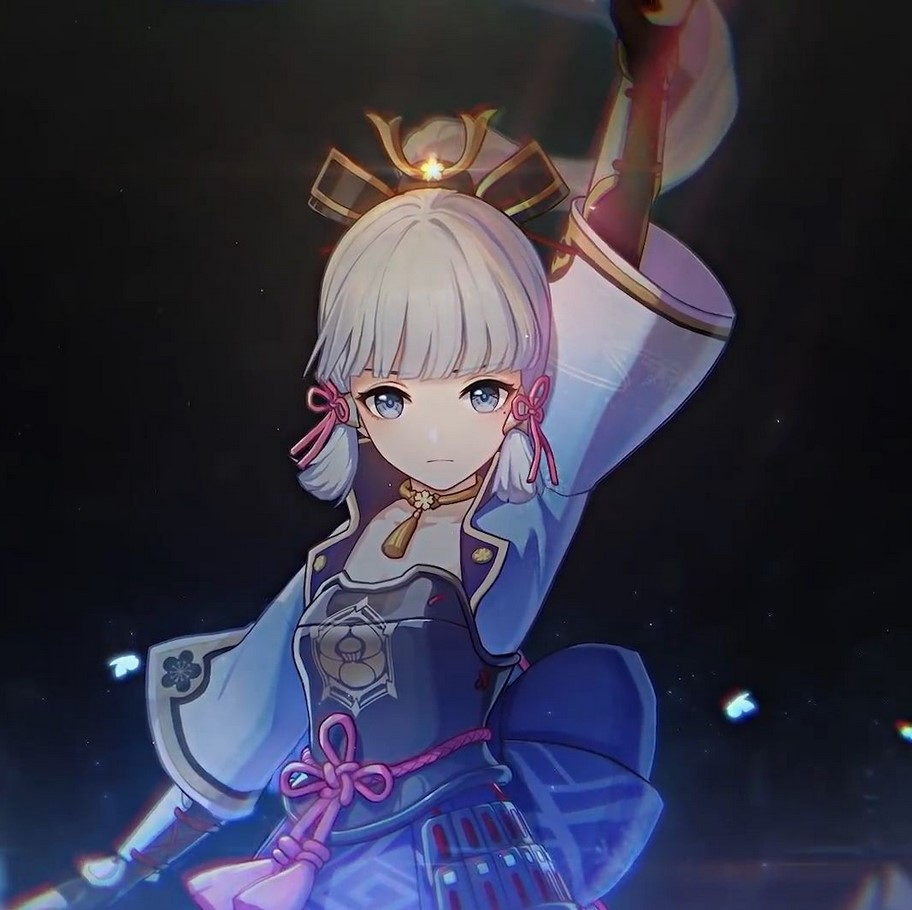

The matched document agains query Ayaka dancing at position 2 is Ayaka


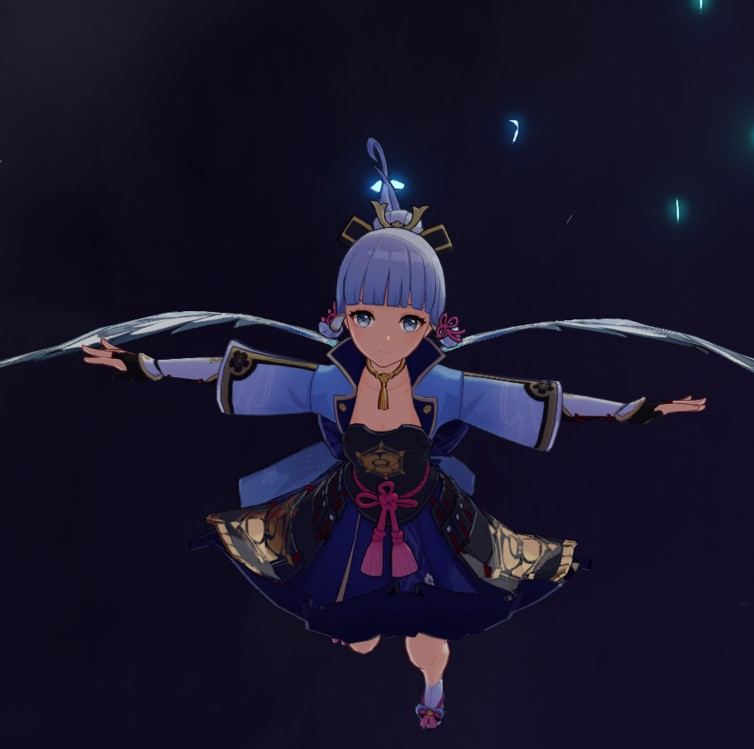

The matched document agains query Ayaka dancing at position 3 is Ayaka


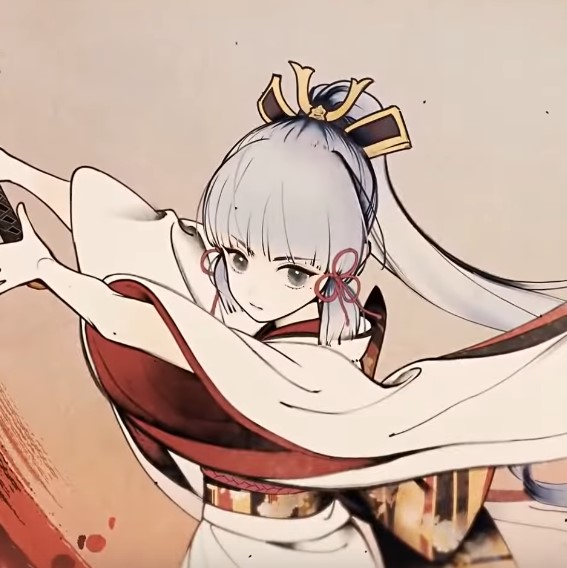

The matched document agains query Ayaka dancing at position 4 is Ayaka


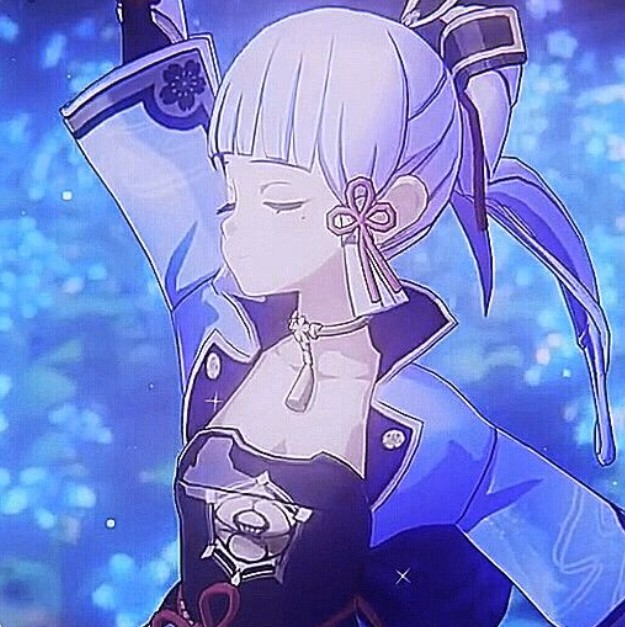

In [ ]:
# embed a user query
query = 'Ayaka dancing'
query_docs = DocumentArray([Document(content=query)])
query_docs.apply(preprocess_and_encode_text)
# find top 5 matches
query_docs.match(test_da, metric='cosine', limit=5)
# plot matches
for idx, match in enumerate(query_docs[0].matches):
    print(f'The matched document agains query \033[1m{query}\033[0m at position \033[1m{idx}\033[0m is \033[1m{match.tags["finetuner_label"]}\033[0m')
    match.display()

The matched document agains query Albedo flying at position 0 is Neither


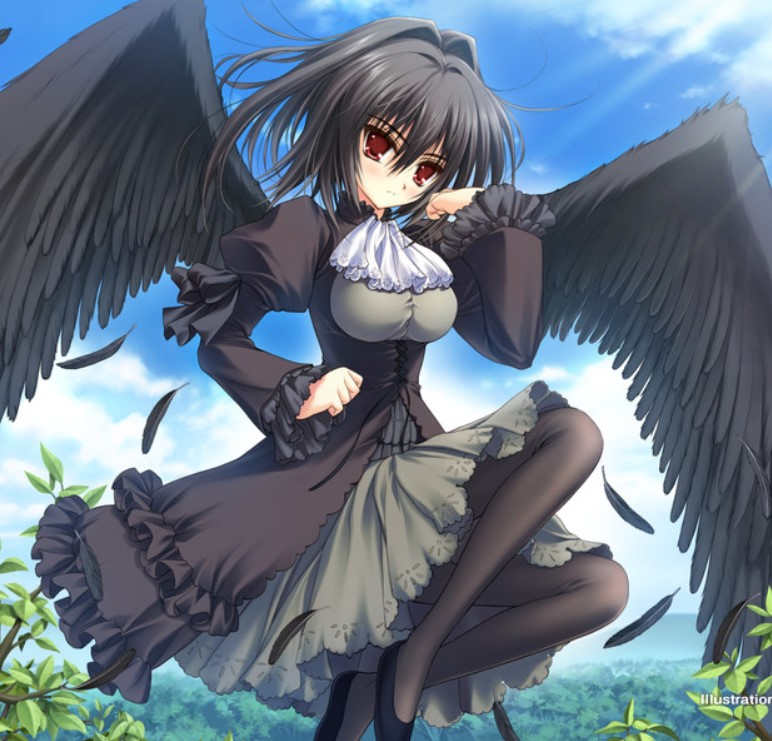

The matched document agains query Albedo flying at position 1 is Neither


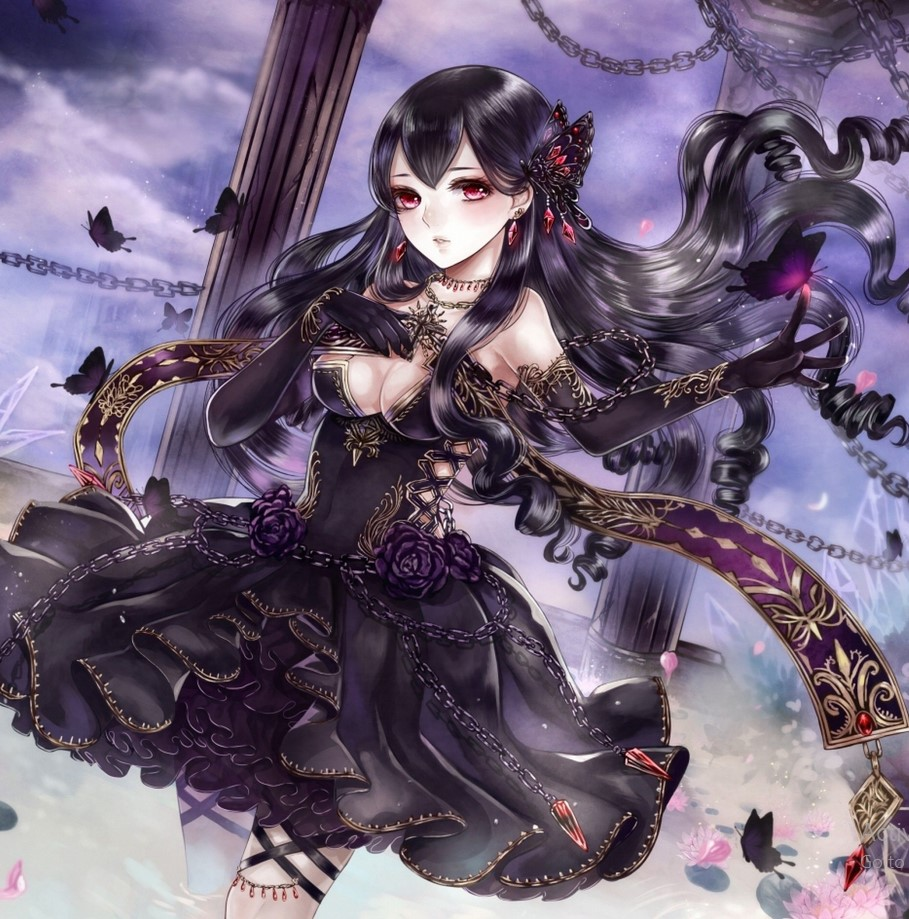

The matched document agains query Albedo flying at position 2 is Neither


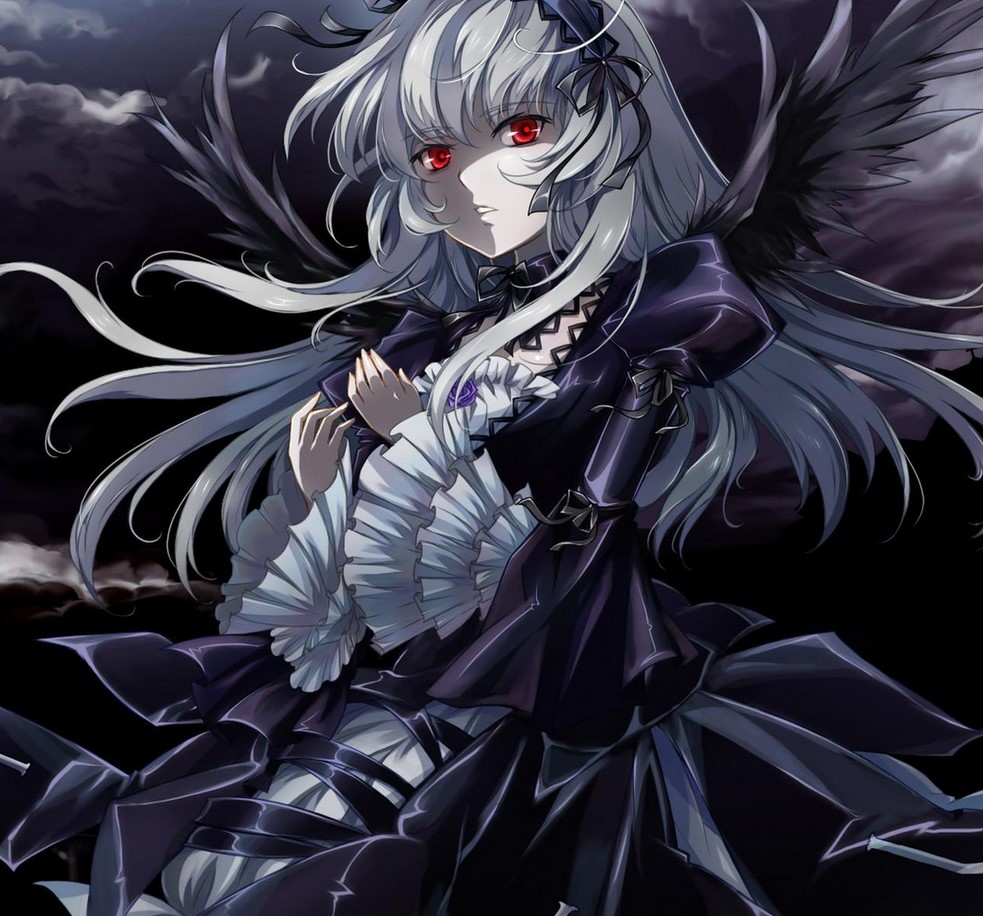

The matched document agains query Albedo flying at position 3 is Neither


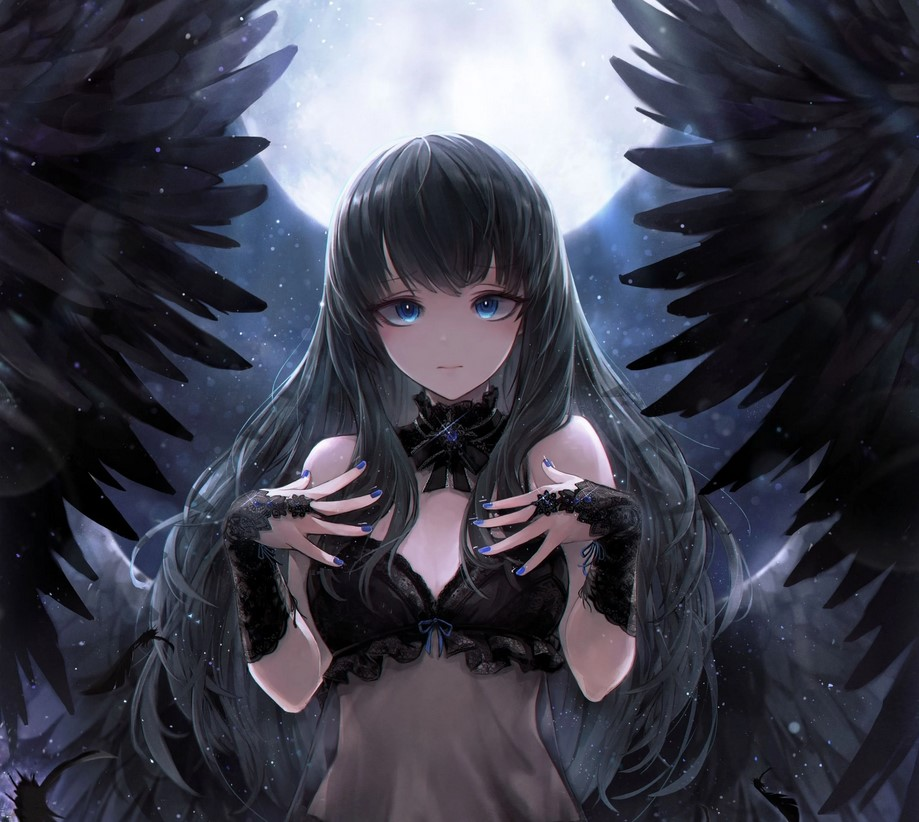

The matched document agains query Albedo flying at position 4 is Ayaka


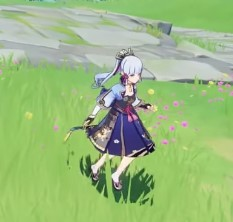

In [ ]:
# embed a user query
query = 'Albedo flying'
query_docs = DocumentArray([Document(content=query)])
query_docs.apply(preprocess_and_encode_text)
# find top 5 matches
query_docs.match(test_da, metric='cosine', limit=5)
# plot matches
for idx, match in enumerate(query_docs[0].matches):
    print(f'The matched document agains query \033[1m{query}\033[0m at position \033[1m{idx}\033[0m is \033[1m{match.tags["finetuner_label"]}\033[0m')
    match.display()

As you can see we created three user queries:

1. `Hu Tao Fighting`: In the top five results we only got one match. While thre matches are related to Ayaka.
2. `Ayaka dancing`: In this case, zero-shot CLIP returns good results. One of the reasons is that in Genshin Impact [Ayaka's cutscene](https://youtu.be/g-o-l8j6d8Q) is dancing, this is rare for other characters.
3. `Albedo flying`: This is a hard query, and as expected, none of the returned matches are related to Albedo, while most of the images are indeed related to flying.

So it's ok-ish but now, let's fine-tune CLIP to see if we can get better results.

## CLIP Fine-tuning

Fine-tuning the CLIP model is not easy. It involves two models: the `clip image encoder` and `clip text encoder` and optimize the clip loss jointly. Luckily, the package `finetuner` makes it easy!

The GitHub repo: https://github.com/jina-ai/finetuner

The documentation: https://finetuner.jina.ai/

In short, `finetuner` receives a `DocumentArray` as training data and ouputs an `artifact`. For the case of CLIP, the `artifact` contains 2 onnx files (for speeding up inference). We'll come back to this later.

In [ ]:
import finetuner


finetuner.notebook_login(force=True)

Now we need to prepare training data for CLIP. As you might already know CLIP was trained on pairs of textual data and image data, it can be organized as a `Document` with two `chunks` inside. For example:

```python
train_da = DocumentArray([
    Document(
        chunks=[
            Document(
                content='pencil skirt slim fit available for sell',
                modality='text',
            ),
            Document(
                uri='https://...skirt-1.png',
                modality='image',
            ),
        ],
    ),
    ...# more documents
])
```

We just need to clean up our `train_da` to adopt the above form. It should be noted that if an image is stored locally, you can convert it to a `tensor` object:

In [ ]:
pairs = DocumentArray() # initialize a DocumentArray as final training data.

prompt = 'This is a photo of '
for doc in train_da:
    pair = Document()
    img_chunk = doc.load_uri_to_image_tensor(224, 224)
    img_chunk.modality = 'image'
    txt_chunk = Document(content=prompt + doc.tags['finetuner_label'])
    txt_chunk.modality = 'text'
    pair.chunks.extend([img_chunk, txt_chunk])
    # add pair to pairs
    pairs.append(pair)

# Lets see the first item of the pairs
pairs[0]

📄 Document: be3f1e7ec973cacdd50f1b3fbc415e36
└── 💠 Chunks
    ├── 📄 Document: b4718b1a2862bdd11fba766ec6314d24
    │   ╭────────────┬─────────────────────────────────────────────────────────────────╮
    │   │ Attribute  │ Value                                                           │
    │   ├────────────┼─────────────────────────────────────────────────────────────────┤
    │   │ tensor     │ <class 'numpy.ndarray'> in shape (224, 224, 3), dtype: uint8    │
    │   │ mime_type  │ image/jpeg                                                      │
    │   │ uri        │ /content/dataset/Kokomi/36.jpg                                  │
    │   │ tags       │ {'finetuner_label': 'Kokomi'}                                   │
    │   │ modality   │ image                                                           │
    │   ╰────────────┴─────────────────────────────────────────────────────────────────╯
    └── 📄 Document: 6d50a7d64fe9c2b4da05c6eb6e131fd2
        ╭───────────────────────┬──────────────────────────────────────────────────────╮
        │ Attribute             │ Value                                                │
        ├───────────────────────┼──────────────────────────────────────────────────────┤
        │ text                  │ This is a photo of Kokomi                            │
        │ modality              │ text                                                 │
        ╰───────────────────────┴──────────────────────────────────────────────────────╯

In [ ]:
len(pairs)

250

As you can see above, now we have a list of pairs of `Document`s which forms a `DocumentArray`, in each pair, we have:

1. An `image chunk`: containing the image `tensor` object and `modality='image'`
2. A `text_chunk`: containing the `text` which is identical to the prompt and the name of the character (e.g. `this is a photo of Ayaka`) and `modality='text'`.

Now, we are ready to train our model.

Before training, something basic concepts to be aware of is that:

1. `experiment` and `run`: represent how your different settings are organized: an experiment contains multiple runs with different hyper-parameter settings for your fine-tuning job.
2. Once you call `finetuner.fit` function, it will schedule CPU/GPU/memory and all computation resources in the cloud (for free!).

In [ ]:
run = finetuner.fit(
    model='openai/clip-vit-base-patch32', # fine-tune CLIP
    train_data=pairs,   
    learning_rate=1e-5,
    loss='CLIPLoss',
    cpu=False,
)

Pushing a DocumentArray to Hubble under the name finetuner-dastorage-content-brave-lamport-train ...


🔐 You are logged in to Jina AI as team-finetuner. To log out, use jina auth logout.

Output()

Model fine-tuning might take some time. You can trace your job with:

In [ ]:
for entry in run.stream_logs():
    print(entry)

Output()

[20:09:31] INFO     Starting finetuner run ...                                                           __main__.py:113
           DEBUG    Found Jina AI Cloud authentication token                                             __main__.py:125
           DEBUG    Running in online mode                                                               __main__.py:126
           INFO     Reading config ...                                                                   __main__.py:133
           DEBUG    Reading config from stream                                                           __main__.py:145
           INFO     Parsing config ...                                                                   __main__.py:148
           INFO     Config loaded 📜                                                                     __main__.py:150
           INFO     Run name: brave-lamport                                                              __main__.py:152
           INFO     Experiment na

In [ ]:
# save the artifact
artifact = run.save_artifact('/content/')

Output()

In [ ]:
clip_text_encoder = finetuner.get_model(artifact=artifact, select_model='clip-text')
clip_image_encoder = finetuner.get_model(artifact=artifact, select_model='clip-vision')

Downloading:   0%|          | 0.00/577M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

In [ ]:
finetuner.encode(model=clip_image_encoder, data=test_da)

Output()

Output()

The matched document again query Hu Tao flying at position 0 is Hu Tao


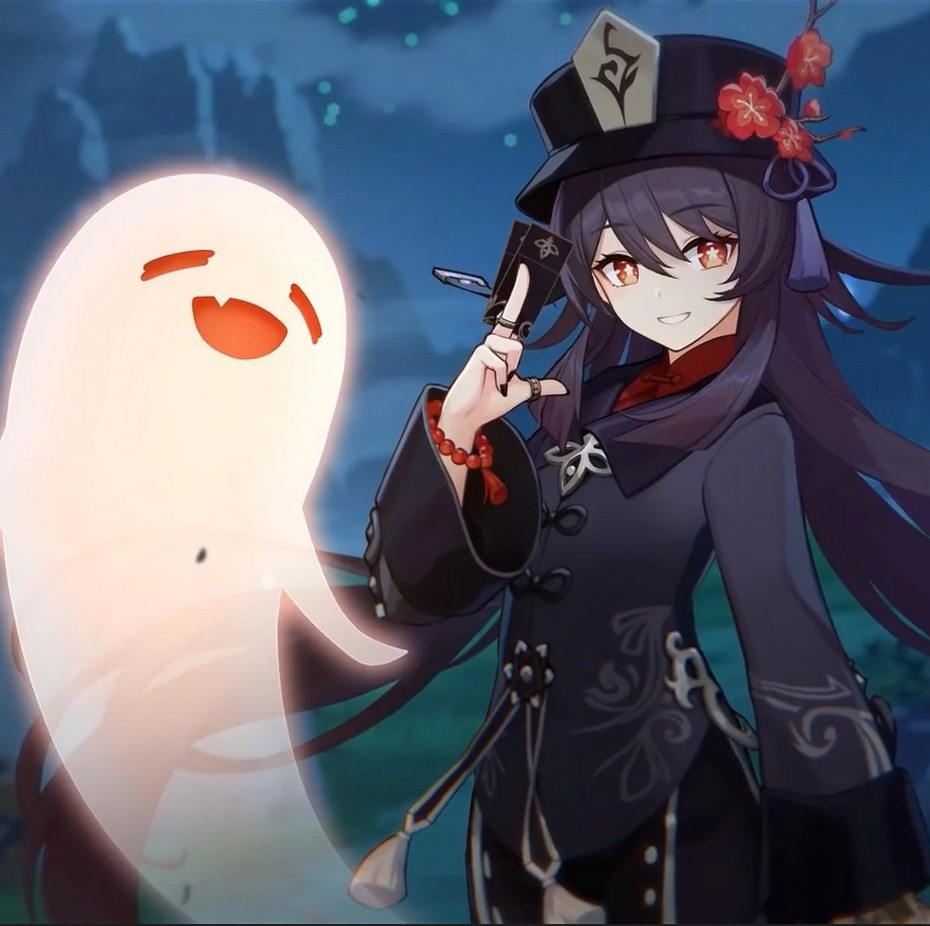

The matched document again query Hu Tao flying at position 1 is Hu Tao


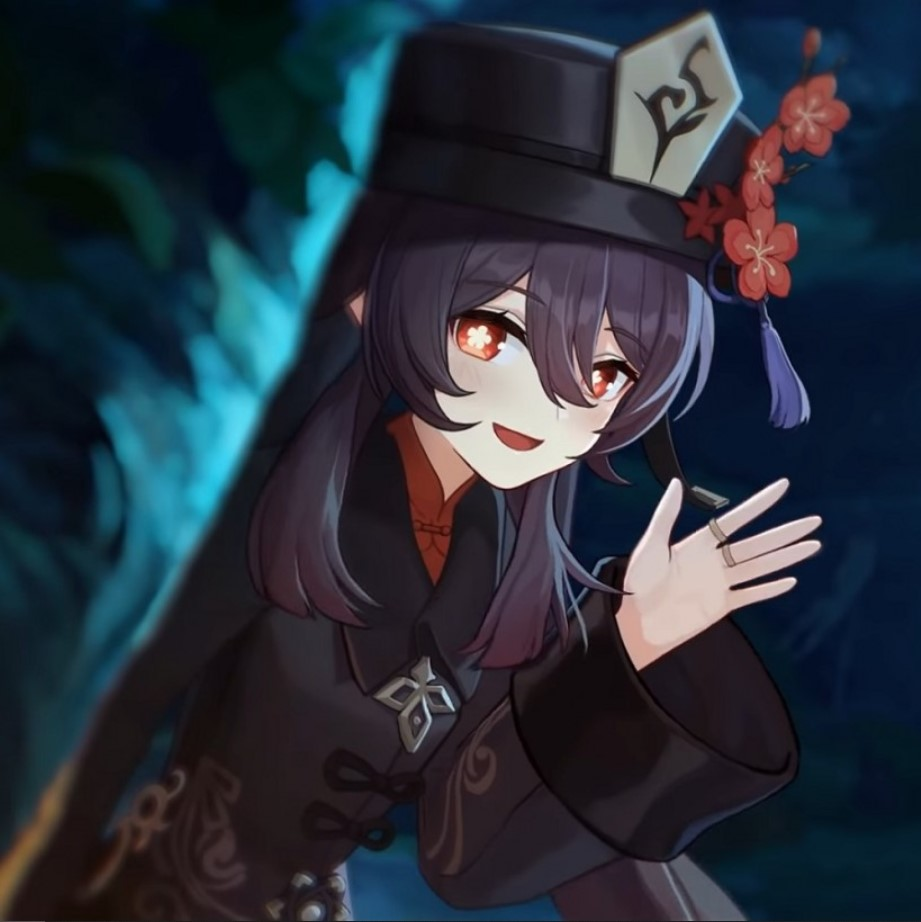

The matched document again query Hu Tao flying at position 2 is Hu Tao


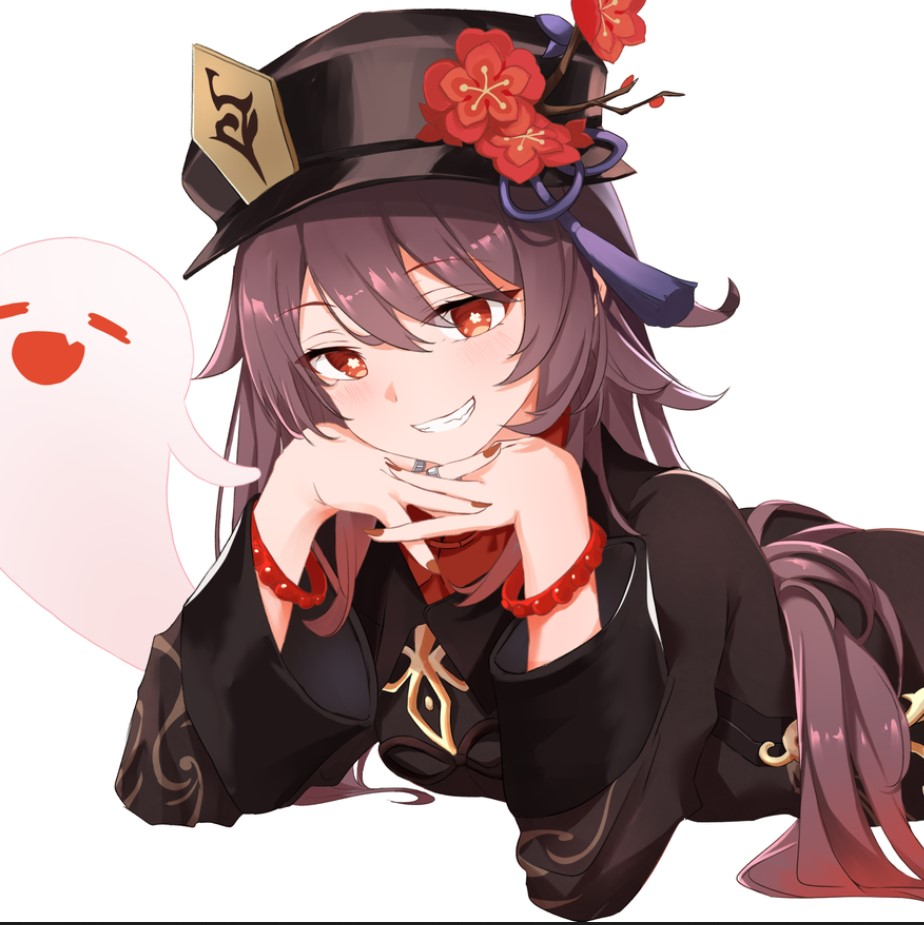

The matched document again query Hu Tao flying at position 3 is Hu Tao


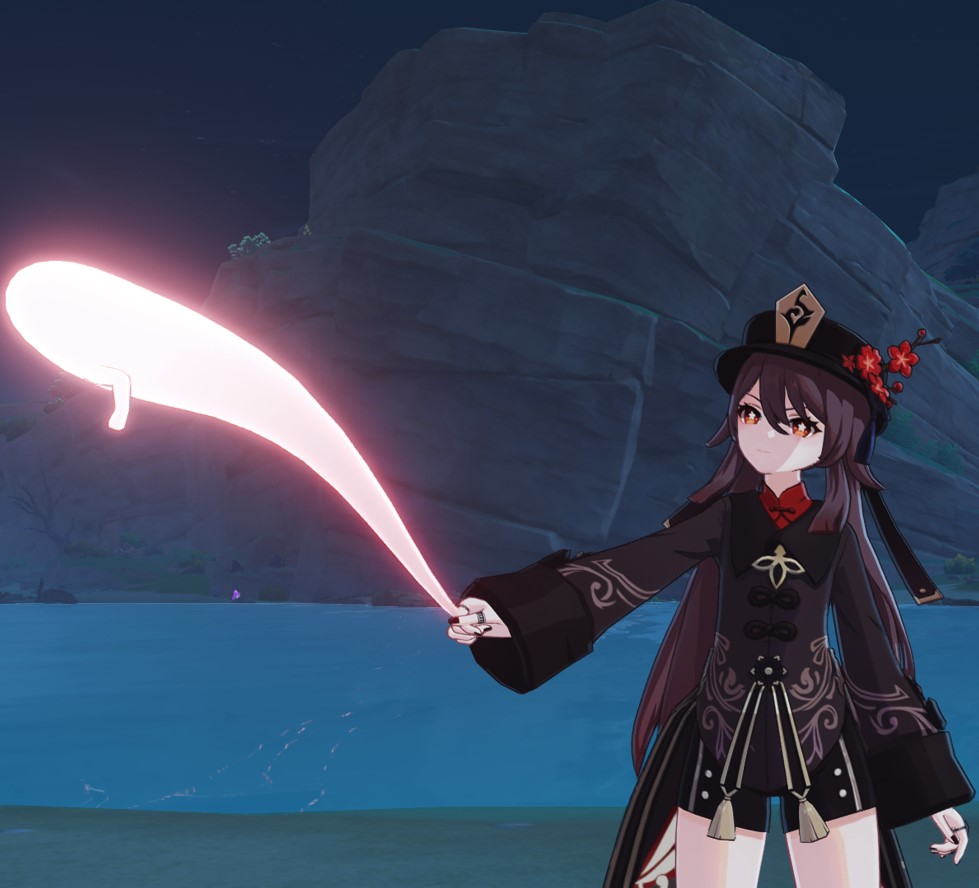

The matched document again query Hu Tao flying at position 4 is Hu Tao


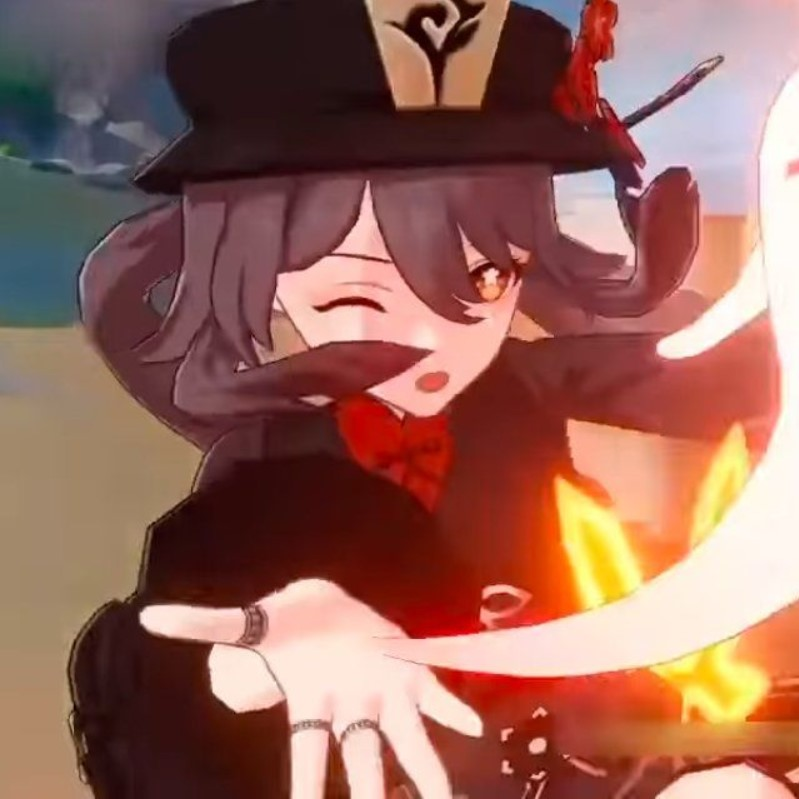

In [ ]:
# embed a user query, in this case, the query keywords is "Hu Tao fighting"
query = 'Hu Tao flying'
query_docs = DocumentArray([Document(content=query)])

finetuner.encode(model=clip_text_encoder, data=query_docs)
# find top 5 matches
query_docs.match(test_da, metric='cosine', limit=5)
# plot matches
for idx, match in enumerate(query_docs[0].matches):
    print(f'The matched document again query \033[1m{query}\033[0m at position \033[1m{idx}\033[0m is \033[1m{match.tags["finetuner_label"]}\033[0m')
    match.display()

Output()

The matched document again query Ayaka dancing at position 0 is Ayaka


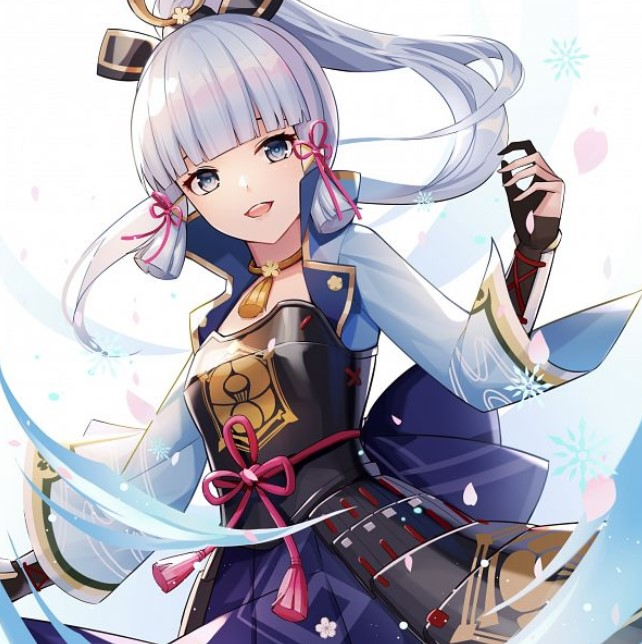

The matched document again query Ayaka dancing at position 1 is Ayaka


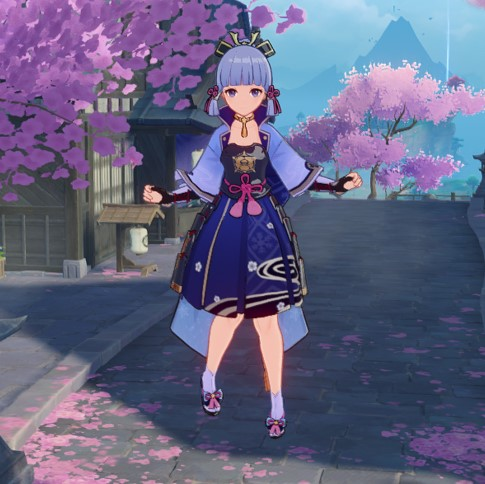

The matched document again query Ayaka dancing at position 2 is Ayaka


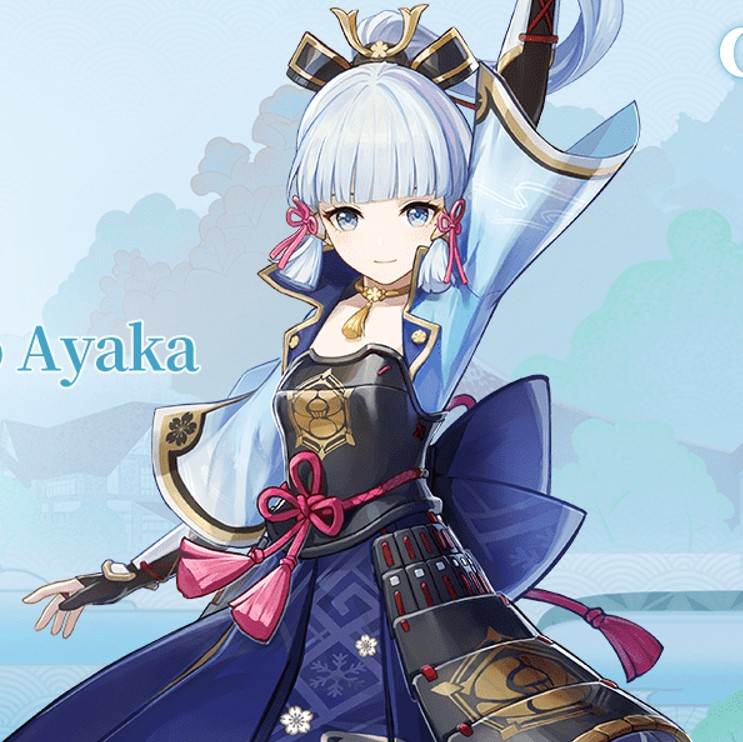

The matched document again query Ayaka dancing at position 3 is Ayaka


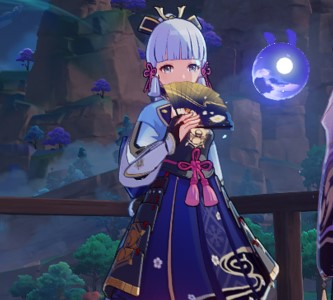

The matched document again query Ayaka dancing at position 4 is Ayaka


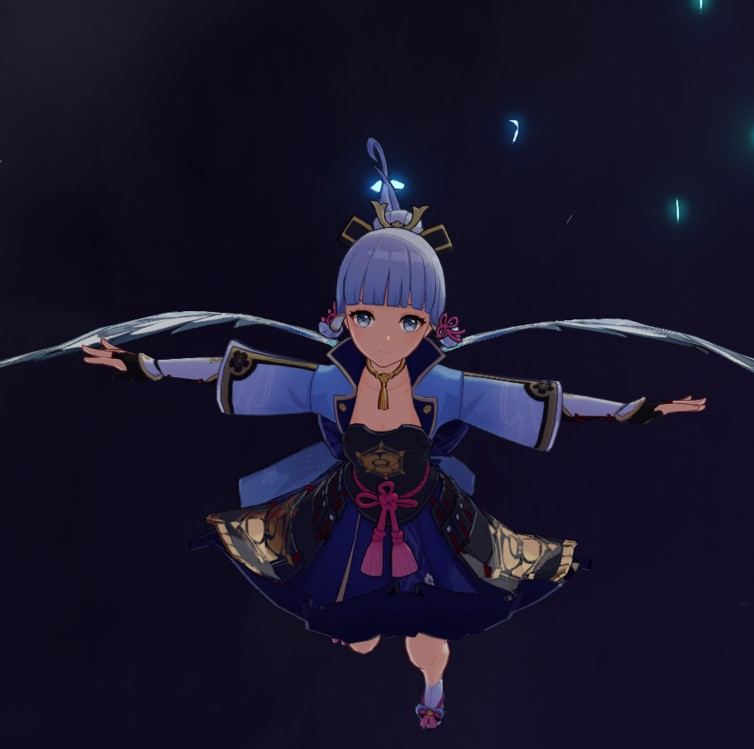

In [ ]:
# embed a user query.
query = 'Ayaka dancing'
query_docs = DocumentArray([Document(content=query)])

finetuner.encode(model=clip_text_encoder, data=query_docs)
# find top 5 matches
query_docs.match(test_da, metric='cosine', limit=5)
# plot matches
for idx, match in enumerate(query_docs[0].matches):
    print(f'The matched document again query \033[1m{query}\033[0m at position \033[1m{idx}\033[0m is \033[1m{match.tags["finetuner_label"]}\033[0m')
    match.display()

Output()

The matched document again query Albedo flying at position 0 is Albedo


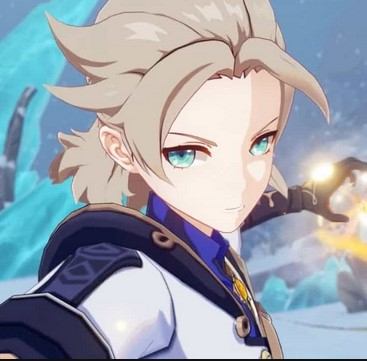

The matched document again query Albedo flying at position 1 is Albedo


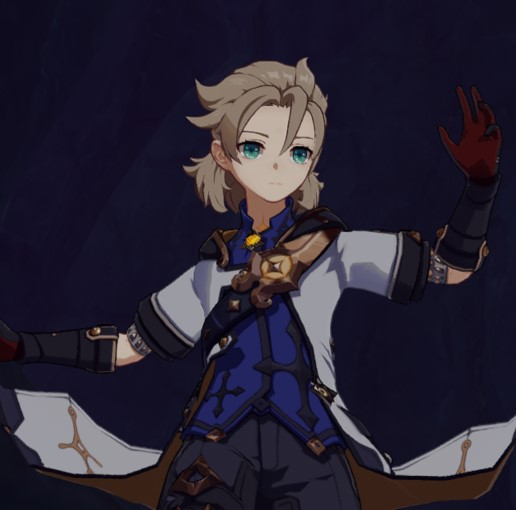

The matched document again query Albedo flying at position 2 is Albedo


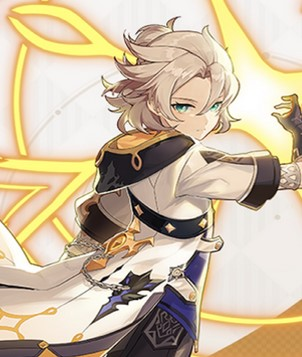

The matched document again query Albedo flying at position 3 is Albedo


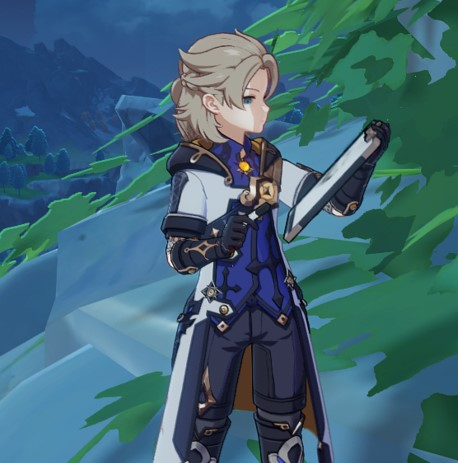

The matched document again query Albedo flying at position 4 is Albedo


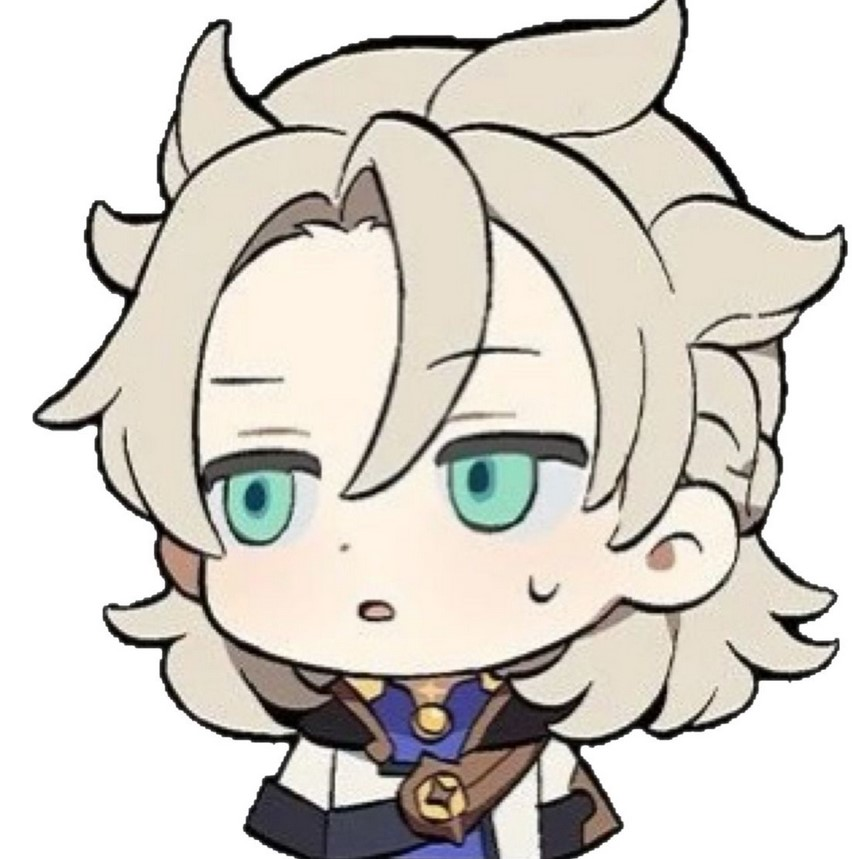

In [ ]:
# embed a user query.
query = 'Albedo flying'
query_docs = DocumentArray([Document(content=query)])

finetuner.encode(model=clip_text_encoder, data=query_docs)
# find top 5 matches
query_docs.match(test_da, metric='cosine', limit=5)
# plot matches
for idx, match in enumerate(query_docs[0].matches):
    print(f'The matched document again query \033[1m{query}\033[0m at position \033[1m{idx}\033[0m is \033[1m{match.tags["finetuner_label"]}\033[0m')
    match.display()

Let's see the results!

1. `Hu Tao Fighting`: In top 5 results we only got 2 matches. Compared with before, minor improvements.
2. `Ayaka dancing`: In this case, zero-shot CLIP returns nice results. Compared with before, all matched results are Ayaka and also related to her dancing scene!
3. `Albedo flying`: This is a hard query, previously, we got 0 matches. Now, all images are Albedo images, and some of them are flying albedo!

End thoughts:

1. Fine-tuning CLIP with only 250 samples can already improve CLIP on retrieval a lot!